In [1]:
import sys
sys.path.append("../")
import os
print(os.getcwd())
%pylab inline
import GPyOpt
import GPy
from AlphaOpt import components

/Users/tardis/Developer/nus/AlphaOpt/modelling
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Helper functions
def get_model_with(model, space, objective, a, e, x, c=None):
    return GPyOpt.methods.ModularBayesianOptimization(model=model,
                                                space=space,
                                                objective=objective,
                                                acquisition=a,
                                                evaluator=e,
                                                X_init=x,
                                                cost=c)

def get_diff_from_optimal_X(true, experimental):
    if(type(true) == float):
        return (true-experimental[0])
    min_pos1, min_pos2 = true[0], true[1]
    if (sum_ae(min_pos1, experimental) < sum_ae(min_pos2, experimental)):
        return (min_pos1-experimental)[0]
    else:
        return (min_pos2-experimental)[0]
        
def sum_ae(val1, val2): # Sum of absolute errors; or should we do Absolute sum of errors? :hm:
    return abs(val1[0] - val2[0]) + abs(val1[1] - val2[1])

def print_results(f=None, bl=None, *args):
    print("Baseline X's: {}".format(bl.x_opt))
    for i in range(len(args)):
        print("{} X's: {}".format(args[i].acquisition.__class__.__name__, args[i].x_opt))
    print("Baseline best y(x): {}".format(bl.fx_opt))
    for i in range(len(args)):
        print("{} best y(x): {}".format(args[i].acquisition.__class__.__name__, args[i].fx_opt))

    print("Baseline x_err: {}".format(get_diff_from_optimal_X(f.min, bl.x_opt)))
    for i in range(len(args)):
        print("{} x_err: {}".format(args[i].acquisition.__class__.__name__, get_diff_from_optimal_X(f.min, args[i].x_opt)))

    errs = [abs(f.f(bl.x_opt)-f.fmin)]
    print("Baseline f_err: {}".format(abs(f.f(bl.x_opt)-f.fmin)[0][0]))
    for i in range(len(args)):
        err = abs(f.f(args[i].x_opt)-f.fmin)
        errs.append(err)
        print("{} f_err: {}".format(args[i].acquisition.__class__.__name__, err[0][0]))
    print("Min abs. error = {}".format(min(errs)[0]))


In [3]:
from GPyOpt.objective_examples.experiments1d import *
from GPyOpt.objective_examples.experiments2d import *

# Output
func  = branin()
y = branin(sd=1.)
input_dim = 2
objective = GPyOpt.core.task.SingleObjective(lambda x: y.f(x))

# Input
v1_dom = func.bounds[0]
v2_dom = func.bounds[1]

space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'continuous', 'domain': v1_dom},
                                   {'name': 'var_2', 'type': 'continuous', 'domain': v2_dom}])

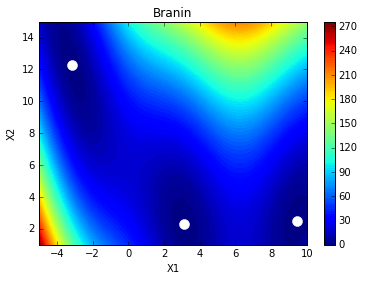

In [4]:
# The true function
func.plot()

In [5]:
# Bayesian Optimization Components
# GP models
kernel = GPy.kern.Matern52(input_dim=input_dim, ARD=True)
model = GPyOpt.models.GPModel(kernel=kernel, optimize_restarts=10,verbose=False)

# Cost model
# cost = GPyOpt.core.task.CostModel('evaluation_time')

In [6]:
# Imports for Acquisition function
from GPyOpt.acquisitions import AcquisitionBase, AcquisitionEI
from GPyOpt.core.task.cost import constant_cost_withGradients
from GPyOpt.util.general import get_quantiles
import math
import numpy as np

In [7]:
class EIXplore(AcquisitionBase):
    analytical_gradient_prediction = False
    
    jitter = 0
    
    explore = 0
    cycle = 3
    
    prev = None

    def __init__(self, model, space, optimizer, cost_withGradients=None, jitter=0.01, cycle=3):
        super(EIXplore, self).__init__(model, space, optimizer)

        self.jitter = jitter
        self.cycle = cycle
        if cost_withGradients == None:
             self.cost_withGradients = constant_cost_withGradients
        else:
             self.cost_withGradients = cost_withGradients 


    def _compute_acq(self,x):
        m, s = self.model.predict(x)
        fmin = self.model.get_fmin()
        phi, Phi, _ = get_quantiles(self.jitter, fmin, m, s)
        h = 0.5 * np.log(2*math.pi*math.e*np.square(s))
        if self.prev != None and abs(self.prev-fmin) < 1:
            self.prev = fmin
            return h
        
        self.prev = fmin
        f_acqu_x = h if (self.explore % self.cycle) == 0 else (fmin - m + self.jitter) * Phi + s * phi
        self.explore += 1
        self.explore %= self.cycle
        return f_acqu_x

In [8]:
class EntropyWeightedEI(AcquisitionBase):
    analytical_gradient_prediction = False

    def __init__(self, model, space, optimizer, cost_withGradients=None):
        super(EntropyWeightedEI, self).__init__(model, space, optimizer)
        
        self.EI = AcquisitionEI(model, space, optimizer, cost_withGradients)

        if cost_withGradients == None:
             self.cost_withGradients = constant_cost_withGradients
        else:
             self.cost_withGradients = cost_withGradients 


    def _compute_acq(self,x):
        m, s = self.model.predict(x)
        acqu_x = self.EI.acquisition_function(x)
        
        h = 0.5 * np.log(2*math.pi*math.e*np.square(s))
        for i in range (acqu_x.shape[0]):
            acqu_x[i] += h[i]
        return acqu_x

In [9]:
class EntropyExplore(AcquisitionBase):
    analytical_gradient_prediction = False

    def __init__(self, model, space, optimizer, cost_withGradients=None):
        super(EntropyExplore, self).__init__(model, space, optimizer)
        
        self.EI = AcquisitionEI(model, space, optimizer, cost_withGradients)

        if cost_withGradients == None:
             self.cost_withGradients = constant_cost_withGradients
        else:
             self.cost_withGradients = cost_withGradients 


    def _compute_acq(self,x):
        m, s = self.model.predict(x)
        h = 0.5 * np.log(2*math.pi*math.e*np.square(s))
        return h

In [10]:
class PITarget(AcquisitionBase):
    analytical_gradient_prediction = True

    def __init__(self, model, space, optimizer=None, cost_withGradients=None, jitter=3, target=None):
        super(PITarget, self).__init__(model, space, optimizer, cost_withGradients=cost_withGradients)
        self.jitter = jitter
        self.evaluations = 0
        self.target = 1 if target is None else target

    def _compute_acq(self, x):
        m, s = self.model.predict(x)
        fmin = self.target if self.target is not None else self.model.get_fmin()
        _, Phi, _ = get_quantiles(self.jitter, fmin, m, s)    
        f_acqu = Phi
        self.jitter *= .5
        return f_acqu

    def _compute_acq_withGradients(self, x):
        fmin = self.target if self.target is not None else self.model.get_fmin()
        m, s, dmdx, dsdx = self.model.predict_withGradients(x)
        phi, Phi, u = get_quantiles(self.jitter, fmin, m, s)    
        f_acqu =  Phi        
        df_acqu = -(phi/s)* (dmdx + dsdx * u)

        self.jitter *= .5
        return f_acqu, df_acqu

In [11]:
# Decision models
acq_opt = GPyOpt.optimization.AcquisitionOptimizer(space)

# Use EI as the baseline
acq_fxs = [GPyOpt.acquisitions.AcquisitionEI(model, space, acq_opt), 
          EIXplore(model, space, acq_opt),
          EntropyWeightedEI(model, space, acq_opt),
          EntropyExplore(model, space, acq_opt),
          PITarget(model, space, acq_opt, target=func.fmin)]

eval_fxs = []
for i in range(len(acq_fxs)):
    eval_fxs.append(GPyOpt.core.evaluators.Sequential(acq_fxs[i]))

In [12]:
# Initial points
X_init = GPyOpt.util.stats.initial_design('random', space, 2)
# Do BO for baseline and custom
models = []
for i in range(len(acq_fxs)):
    models.append(get_model_with(model, space, objective, acq_fxs[i], eval_fxs[i], X_init))

In [13]:
num_cores=4
models.append(GPyOpt.methods.ModularBayesianOptimization(model=model,
                                                space=space,
                                                objective=GPyOpt.core.task.SingleObjective(y.f, num_cores=num_cores),
                                                acquisition=None,
                                                evaluator=components.MultiAcquisitions(*acq_fxs),
                                                X_init=X_init))

In [14]:
max_iter  = 25
for m in models:
    m.run_optimization(max_iter = max_iter, eps=1e-10, verbosity=True)

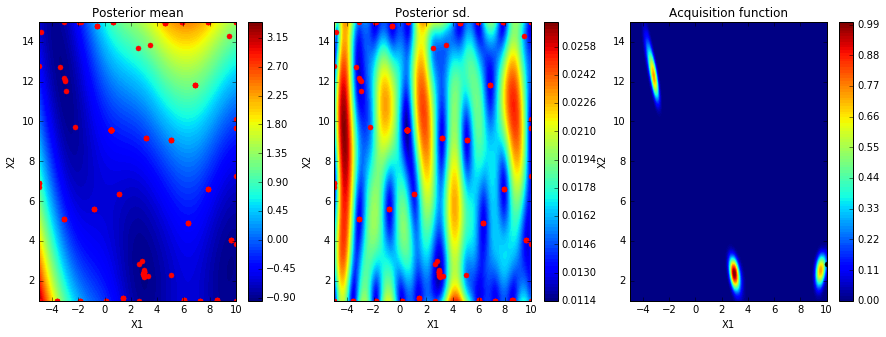

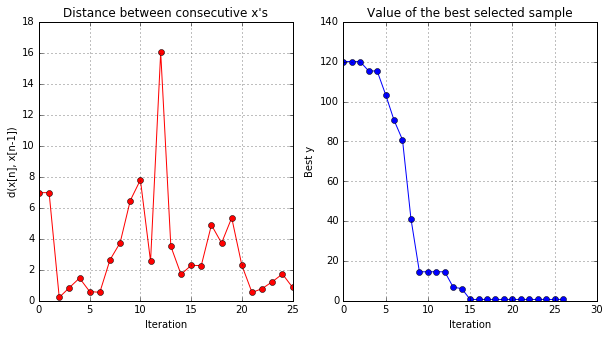

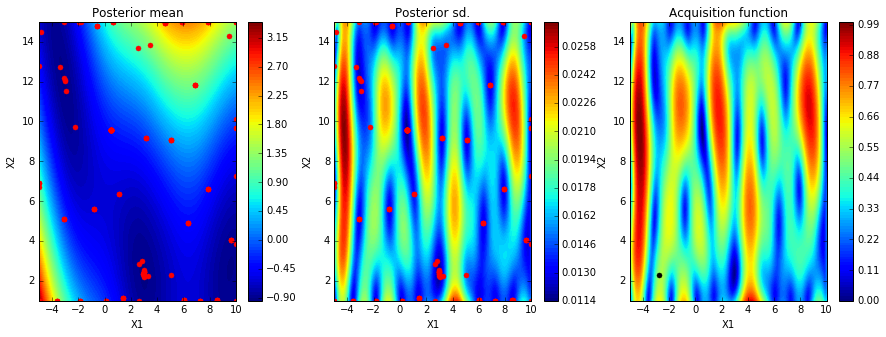

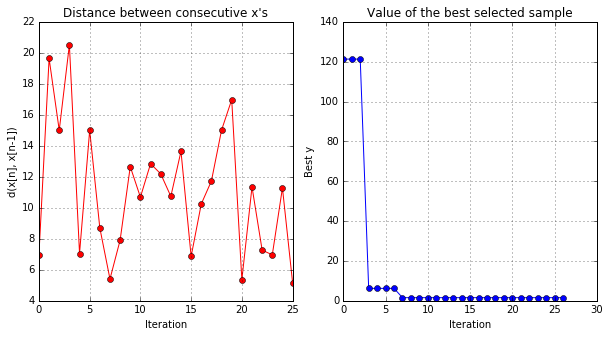

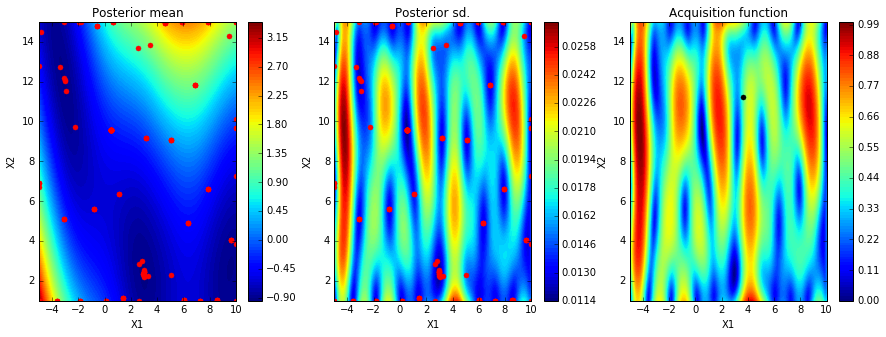

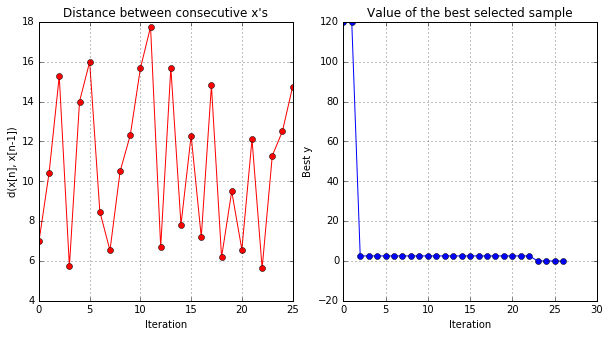

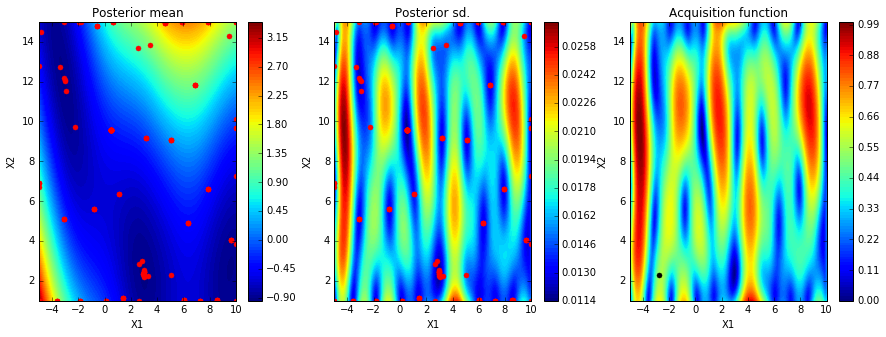

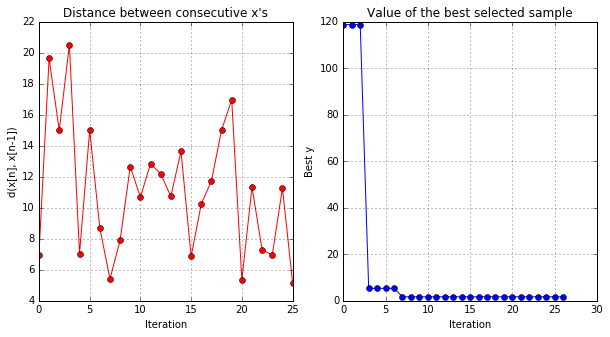

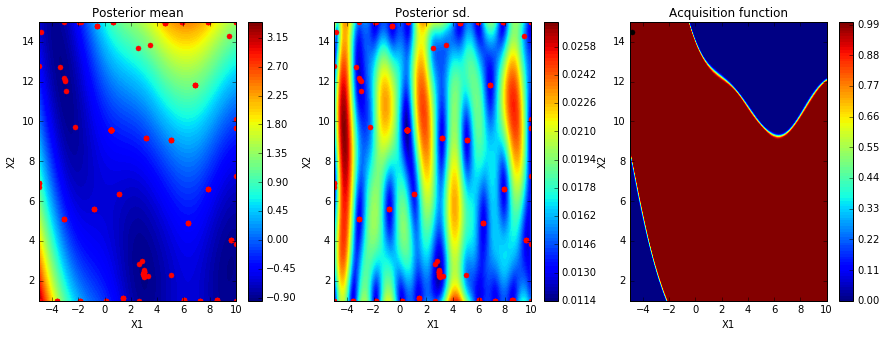

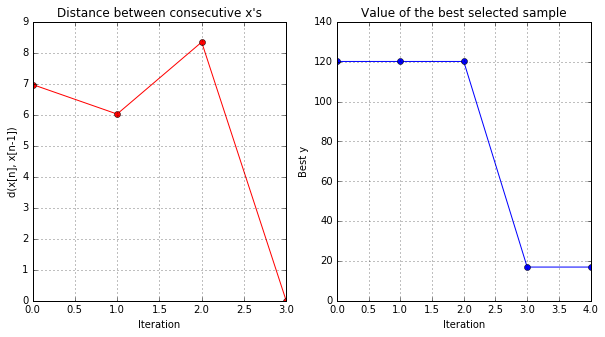

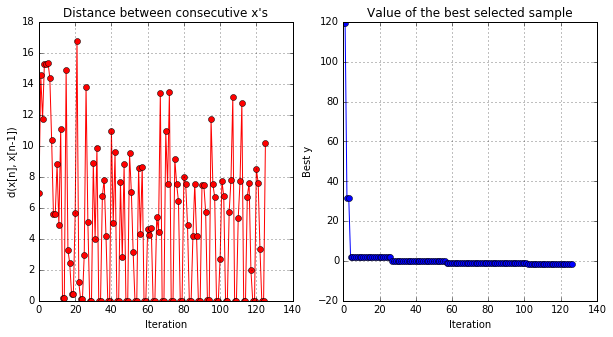

In [17]:
for i in range(len(models)):
    if (i != len(models)-1):
        models[i].plot_acquisition()
    models[i].plot_convergence()

In [18]:
print_results(func, *models)

Baseline X's: [ 10.           2.80897162]
EIXplore X's: [ 10.           3.87381676]
EntropyWeightedEI X's: [ -3.38281783  13.27185424]
EntropyExplore X's: [ 2.4800793   3.26626652]
PITarget X's: [ -4.84566656  14.47275265]
NoneType X's: [ 2.98777689  2.23838961]
Baseline best y(x): [ 0.6704273]
EIXplore best y(x): [ 1.56523096]
EntropyWeightedEI best y(x): [-0.03653912]
EntropyExplore best y(x): [ 1.71267246]
PITarget best y(x): [ 16.9300154]
NoneType best y(x): [-1.69009373]
Baseline x_err: -6.858407346410207
EIXplore x_err: -6.858407346410207
EntropyWeightedEI x_err: 0.24122517674084998
EntropyExplore x_err: 0.661513356847172
PITarget x_err: 1.7040739068236954
NoneType x_err: 0.15381576583527812
Baseline f_err: 1.5828838357115425
EIXplore f_err: 2.303651076070569
EntropyWeightedEI f_err: 0.4458043136172226
EntropyExplore f_err: 2.20087047932983
PITarget f_err: 16.043148668101217
NoneType f_err: 0.13884516933910696
Min abs. error = [ 0.13884517]
